# Tutorial 1. Training RU-Net

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/training-tutorials/1-training_RU-Net.ipynb)

This tutorial demonstrates how to train a RU-Net (Regression-U-Net) for predicting plankton properties. It covers information on:

* Definining Simulation parameters
* Defining RU-Net using tensorflow keras
* Training RU-Net model
* Testing the model on an experimental images 

<img src="https://raw.githubusercontent.com/softmatterlab/Quantitative-Microplankton-Tracker/main/assets/RU-Net.png" alt="drawing" width="500"/>

**NOTE**:
- If you're running this notebook on your local machine, please comment the code in the cell below

In [4]:
!git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
%cd Quantitative-Microplankton-Tracker/training-tutorials/

In [5]:
%matplotlib inline
import os
import sys
sys.path.insert(0, "..")

## 1. Setup
Imports the dependecies needed to run this tutorial.

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import deeptrack as dt

# Load experimental data
experimental_image = np.load("../data/data_figure1/fig1_data.npy")

## 2. Defining training dataset

### 2.1. Defining simulation parameters
We generate simulated holographic images of size 128 x 128 pixels to train the RU-Net. Each image contains plankton holograms of different properties as defined below.

In [7]:
variables = {
    "pix_size": 3.6, # pixel size of the camera in microns - can be modified as per the camera size
    "radius_range": [1.5e-6, 10e-6], # range of the radius of the planktons in microns
    "ri_range": [1.35, 1.38], # range of the Refractive Index of the planktons
    "z_range": [2300, 3000], # z-distance of the plankton in microns (distance from the camera sensor)
    "apod_val": 0.07, #Gaussian apodization value (to account for the coherence of the source beam)
    "z_pixel": 20, # in microns (Ideally this should be the same as the pixel size) Used to reduce the memory usage
}

### 2.2. Defining scatterrer properties
Each plankton is a scatterrer. We use the ```Sphere``` feature of DeepTrack to generate spherical scatterrers. 
Since we are using lensless-holographic setup, planktons can be approximated as spherical objects. All the other properties are automatically filled from the variables defined above in the cell above.

In [8]:
sphere_main = dt.Sphere(
    position=lambda: np.random.rand(2) * 128,
    position_unit="pixel",
    cam_pix_size=variables["pix_size"],
    radius=lambda: variables["radius_range"][0]
    + np.random.rand()
    * (variables["radius_range"][1] - variables["radius_range"][0]),
    refractive_index=lambda: variables["ri_range"][0]
    + np.random.rand() * (variables["ri_range"][1] - variables["ri_range"][0]),
    z=lambda: variables["z_range"][0] / variables["z_pixel"]
    + np.random.rand()
    * (variables["z_range"][1] - variables["z_range"][0])
    / variables["z_pixel"],
)

### 2.3. Defining the optical device
The scatterers are imaged with an optical device. We use the ```Brightfield``` feature of DeepTrack to define a microscope operating at ```wavelength``` of 633 nm.

In [9]:
optics = dt.Brightfield(
    wavelength=633e-9,
    NA=1,
    #resolution=variables["pix_size"] * 1e-6,
    resolution=[variables["pix_size"] * 1e-6, variables["pix_size"] * 1e-6, variables["z_pixel"] * 1e-6],
    magnification=1,
    refractive_index_medium=1.33,
    apod_val=variables["apod_val"],
    upscale=4,
    aberration=lambda apod_val: dt.GaussianApodization(apod_val + np.random.uniform(-1,1)*0.01),
    output_region=(0, 0, 128, 128),
)

### 2.4. Defining noises
We add gaussian noise to the generated images with a blur factor.

In [10]:
from deeptrack.noises import Noise
from skimage.filters import gaussian
class Blurred_Gaussian(Noise):
    """Adds IID Gaussian noise to an image

    Parameters
    ----------
    mu : float
        The mean of the distribution.
    sigma : float
        The root of the variance of the distribution.
    """

    def __init__(self, mu=0, sigma=1,blur=2, **kwargs):
        super().__init__(mu=mu, sigma=sigma,blur=blur, **kwargs)

    def get(self, image, mu, sigma,blur, **kwargs):

        noisy_image = mu  + np.random.randn(*image.shape) * sigma
        noisy_image=gaussian(noisy_image,sigma=blur)
        noisy_image=image+noisy_image
        return noisy_image

noise = Blurred_Gaussian(mu=0, sigma= lambda: .025, blur=0.9+np.random.uniform(0,1)*0.1)

### 2.5. Defining number of planktons in 128 x 128 px image
Each image is defined to contain 5 to 8 number of planktons with randomly sampled properties.

In [11]:
sphere_main_no = lambda: np.random.randint(5, 8)
sample_normal = sphere_main ** sphere_main_no

### 2.6. Combining all the properties defined above
Passing all the features to the optical device to generate sample images.

In [12]:
image_formed = optics(sample_normal)

image_of_particles = dt.ConditionalSetFeature(
    on_true=image_formed + noise,
    on_false=dt.FlipUD(dt.FlipLR(dt.FlipDiagonal(image_formed))) + noise,
    condition="skip_aug",
    skip_aug=False,
)

### 2.7. Visualising an example image

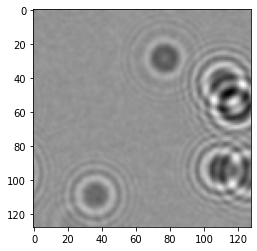

In [13]:
simulated_image = image_of_particles.update(skip_aug=True).resolve()
plt.imshow(simulated_image[:,:,0], cmap="gray")

## 3. Creating target images

### 3.1. Dry mass values
Function to check the range of possible dry mass values for parameters defined above.

In [14]:
def dm_range(rad_range, ri_range):
    m = lambda rad, ri: ((4 * np.pi) / 3) * ((rad * 1e6) ** 3) * (ri - 1.33)
    return m(rad_range[0], ri_range[0]), m(rad_range[1], ri_range[1])


dm_vals = dm_range(variables["radius_range"], variables["ri_range"])
dm_vals

(0.2827433388230816, 209.4395102393188)

### 3.2. Normalising target images
Function to generate the output channels for an input simulated image.

In [15]:
def get_target_image(image_of_particles):
    label = np.zeros((*image_of_particles.shape[:2], 5))

    X, Y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]),
        np.arange(0, image_of_particles.shape[1]),
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]
            distance_map = (X - position[1]) ** 2 + (Y - position[0]) ** 2

            # 2D positions
            label[distance_map < 9, 0] = 1

            # 3D positions
            z = property["z"]

            label[distance_map < 9, 1] = (
                z - variables["z_range"][0] / variables["z_pixel"]
            ) / (
                variables["z_range"][1] / variables["z_pixel"]
                - variables["z_range"][0] / variables["z_pixel"]
            )

            # Dry mass
            rad = property["radius"]
            ri = property["refractive_index"]
            dm = ((4 * np.pi) / 3) * ((rad * 1e6) ** 3) * (ri - 1.33)
            label[distance_map < 9, 2] = (dm - dm_vals[0]) / (
                dm_vals[1] - dm_vals[0]
            )

            label[distance_map < 9, 3] = (
                X[distance_map < 9] - position[1]
            ) / 3

            label[distance_map < 9, 4] = (
                Y[distance_map < 9] - position[0]
            ) / 3

    return label

### 3.3. Visualising sample input and target images

(128, 128, 1)


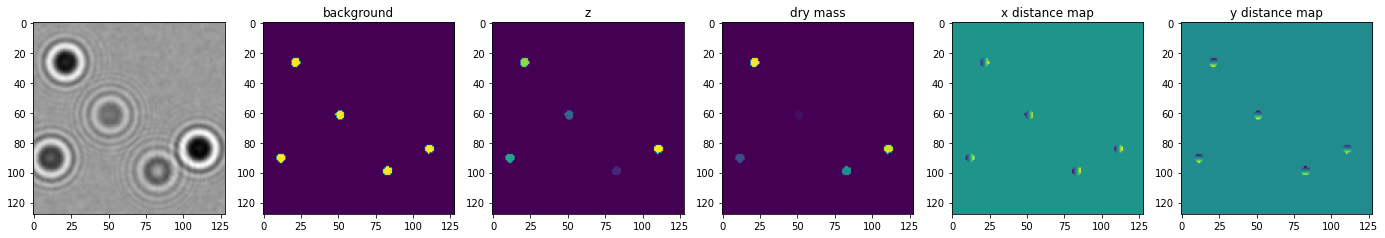

(128, 128, 1)


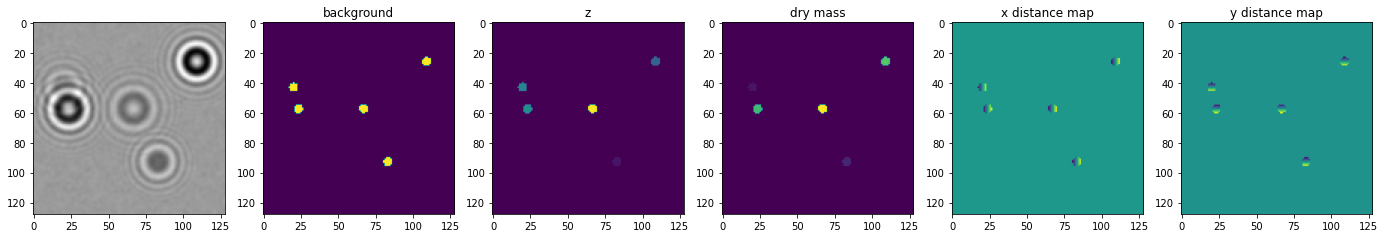

(128, 128, 1)


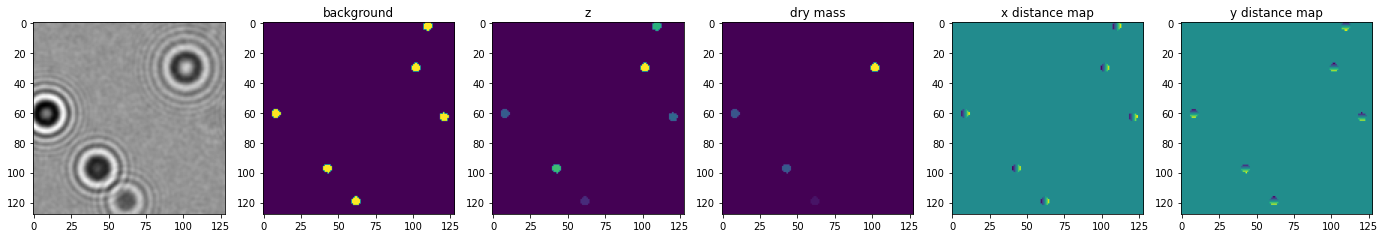

In [16]:
for i in range(3):
    image_of_particles.update(skip_aug=True)
    images = image_of_particles.resolve()
    label_of_particles = get_target_image(images)
    
    fig = plt.figure(figsize=(12*2, 9*2))
    
    print(np.shape(images))
    
    plt.subplot(1, 6,1)
    plt.imshow(images[..., 0], cmap="gray")
    
    plt.subplot(1,6,2)
    plt.title("background")
    plt.imshow(label_of_particles[..., 0])
    
    plt.subplot(1,6,3)
    plt.title("z")
    plt.imshow(label_of_particles[..., 1])
    
    plt.subplot(1,6,4)
    plt.title("dry mass")
    plt.imshow(label_of_particles[..., 2])
    
    plt.subplot(1,6,5)
    plt.title("x distance map")
    plt.imshow(label_of_particles[..., 3])
    
    plt.subplot(1,6,6)
    plt.title("y distance map")
    plt.imshow(label_of_particles[..., 4])
    
    plt.show()

## 4. Training setup
### 4.1. Defining Regression U-Net using keras with a tensorflow backend.

In [17]:
def regressionUNet(
    input_shape=(None, None, 1),
    conv_layers_dimensions=(16, 32, 64, 128),
    upsample_layers_dimensions=(16, 32, 64, 128),
    base_conv_layers_dimensions=(128, 128),
    output_conv_layers_dimensions=(16, 16),
    dropout=(),
    pooldim=2,
    steps_per_pooling=1,
    number_of_outputs=1,
    output_activation=None,
    loss="mae",
    layer_function=None,
    BatchNormalization=False,
    **kwargs
):
    """Creates a Regression U-Net (RU-Net).

    Parameters
    ----------
    input_shape : tuple of ints
        Size of the images to be analyzed.
    conv_layers_dimensions : tuple of ints
        Number of convolutions in each convolutional layer during down-
        and upsampling.
    base_conv_layers_dimensions : tuple of ints
        Number of convolutions in each convolutional layer at the base
        of the unet, where the image is the most downsampled.
    output_conv_layers_dimensions : tuple of ints
        Number of convolutions in each convolutional layer after the
        upsampling.
    steps_per_pooling : int
        Number of convolutional layers between each pooling and upsampling
        step.
    number_of_outputs : int
        Number of convolutions in output layer.
    output_activation : str or keras activation
        The activation function of the output.
    loss : str or keras loss function
        The loss function of the network.
    layer_function : Callable[int] -> keras layer
        Function that returns a convolutional layer with convolutions
        determined by the input argument. Can be use to futher customize the network.

    Returns
    -------
    keras.models.Model
        Deep learning network.
    """

    def conv_step(layer, dimensions):
        layer = tf.keras.layers.Conv2D(
            dimensions, kernel_size=1, activation="relu", padding="same"
        )(layer)
        layern = tf.keras.layers.Conv2D(
            dimensions, kernel_size=3, activation="relu", padding="same"
        )(layer)

        layern = tf.keras.layers.Conv2D(
            dimensions, kernel_size=3, activation="relu", padding="same"
        )(layern)
        layer = tf.keras.layers.Add()([layer, layern])
        return layer

    if layer_function is None:
        layer_function = lambda dimensions: tf.keras.layers.Conv2D(
            conv_layer_dimension,
            kernel_size=3,
            activation="relu",
            padding="same",
        )

    unet_input = tf.keras.layers.Input(input_shape)

    concat_layers = []

    layer = unet_input

    # Downsampling step
    for conv_layer_dimension in conv_layers_dimensions:
        for _ in range(steps_per_pooling):
            layer = layer_function(conv_layer_dimension)(layer)
        concat_layers.append(layer)
        if BatchNormalization:
            layer = tf.keras.layers.BatchNormalization()(layer)
        if dropout:
            layer = tf.keras.layers.SpatialDropout2D(dropout[0])(layer)
            dropout = dropout[1:]

        layer = tf.keras.layers.MaxPooling2D(pooldim)(layer)

    # Base steps
    for conv_layer_dimension in base_conv_layers_dimensions:
        layer = layer_function(conv_layer_dimension)(layer)

    # Upsampling step
    regressionLayer = layer
    for conv_layer_dimension, concat_layer in zip(
        reversed(upsample_layers_dimensions), reversed(concat_layers)
    ):

        layer = tf.keras.layers.Conv2DTranspose(
            conv_layer_dimension, kernel_size=pooldim, strides=pooldim
        )(layer)
        regressionLayer = tf.keras.layers.Conv2DTranspose(
            conv_layer_dimension, kernel_size=pooldim, strides=pooldim
        )(regressionLayer)

        layer = tf.keras.layers.Concatenate(axis=-1)([layer, concat_layer])
        regressionLayer = tf.keras.layers.Concatenate(axis=-1)(
            [regressionLayer, concat_layer]
        )
        for _ in range(steps_per_pooling):
            layer = layer_function(conv_layer_dimension)(layer)
            regressionLayer = layer_function(conv_layer_dimension)(
                regressionLayer
            )

    # Output step
    for conv_layer_dimension in output_conv_layers_dimensions:
        layer = layer_function(conv_layer_dimension)(layer)
        regressionLayer = layer_function(conv_layer_dimension)(regressionLayer)
    layer = tf.keras.layers.Conv2D(
        1,
        kernel_size=3,
        activation="sigmoid",
        padding="same",
        name="segmentationOutput",
    )(layer)

    regressionLayer = tf.keras.layers.Concatenate(axis=-1)(
        [regressionLayer, layer]
    )
    regressionLayer = tf.keras.layers.Conv2D(
        number_of_outputs,
        kernel_size=3,
        activation=output_activation,
        padding="same",
        name="regressionOutput",
    )(regressionLayer)
    outputLayer = tf.keras.layers.Concatenate(axis=-1)(
        [layer, regressionLayer]
    )
    model = tf.keras.models.Model(inputs=unet_input, outputs=outputLayer)

    return model

### 4.2. Defining the loss function
We define a custom loss function as below for RU-Net.

In [18]:
import tensorflow.keras.backend as K

eps = 1e-6


def softmax_categorical(T, P):
    classwise_weight = K.mean(1 - T, axis=(1, 2), keepdims=True)
    true_error = K.mean(T * K.log(P + eps) * classwise_weight, axis=-1)
    return -K.mean(true_error)


def unet_features(weight=(10, 1, 0.1), num_features=1):
    def get_loss(y_true, y_pred):
        T = K.flatten(y_true[:, :, :, 0])
        P = K.flatten(y_pred[:, :, :, 0])

        error = K.abs(T - P)
        loss = -K.mean(
            weight[0] * T * K.log(P + 1e-4)
            + weight[1] * (1 - T) * K.log(1 - P + 1e-4)
        ) / (
            weight[0] + weight[1]
        )
        for i in range(num_features):

            T1 = K.flatten(y_true[:, :, :, i + 1])
            P1 = K.flatten(y_pred[:, :, :, i + 1])
            error = K.abs(T1 - P1)
            f_loss = K.sum(T * error) / (K.sum(T) + 1e-6) + K.sum(
                error * (1 - T)
            ) / (K.sum(1 - T) + 1e-6)
            loss += weight[2] * f_loss

        return loss

    return get_loss

### 4.3. Defining the model parameters 

In [19]:
model = regressionUNet(
    (None, None, 1),
    conv_layers_dimensions=[8, 16, 32, 64],
    base_conv_layers_dimensions=[32, 32],
    number_of_outputs=4,
    output_conv_layers_dimensions=[32, 32],
    loss=unet_features(num_features=4, weight=(1, 1, 1)),
    output_activation=None,
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 8 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1168        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [20]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.0001, amsgrad=True),
    loss=unet_features(num_features=4, weight=(1, 1, 1)),
)

### 4.4. Defining batch function

In [21]:
def batch_function(image):
    return image / np.median(image)

### 4.5. Define generator
The generator generates ```5000``` images before the training begins, and continous to generate another ```5000``` during the training process

In [22]:
generator = dt.generators.ContinuousGenerator(
    image_of_particles,
    get_target_image,
    batch_size=64,
    batch_function=batch_function,
    min_data_size=5000,
    max_data_size=10000,
)

## 5. Training the model
Set the ```TRAIN_MODEL``` = ```True``` to train the model from scratch.
Set the ```TRAIN_MODEL``` = ```False``` to load a pretrained model.

In [23]:
TRAIN_MODEL = False

### 5.1. Generating validation data
Skip this step if would not like to generate validation data

In [24]:
if TRAIN_MODEL:

    print("Generating validation data..")
    b = []
    l = []
    for i in tqdm(range(1000)):
        im = image_of_particles.update().resolve()
        b.append(batch_function(im))
        l.append(get_target_image(im))
    b = np.array(b)
    l = np.array(l)

### 5.2. Start the training
Set the ```TRAIN_MODEL``` to True to train the network from scratch

In [25]:
if TRAIN_MODEL:
    with generator:
        history = model.fit(
            generator,
            epochs=1000,
            steps_per_epoch=16,
            #validation_data=(b, l),
            max_queue_size=0,
            workers=0,
        )

else:

    model.load_weights("../pre-trained-models/RUNet.h5")


## 6. Testing the trained model on experimental image
### 6.1. Normalising the experimental image

In [26]:
img = experimental_image/np.median(experimental_image)
img = img.reshape([1,1024, 1280, 1])
predicted_image = model.predict(img)

### 6.2. Checking predictions

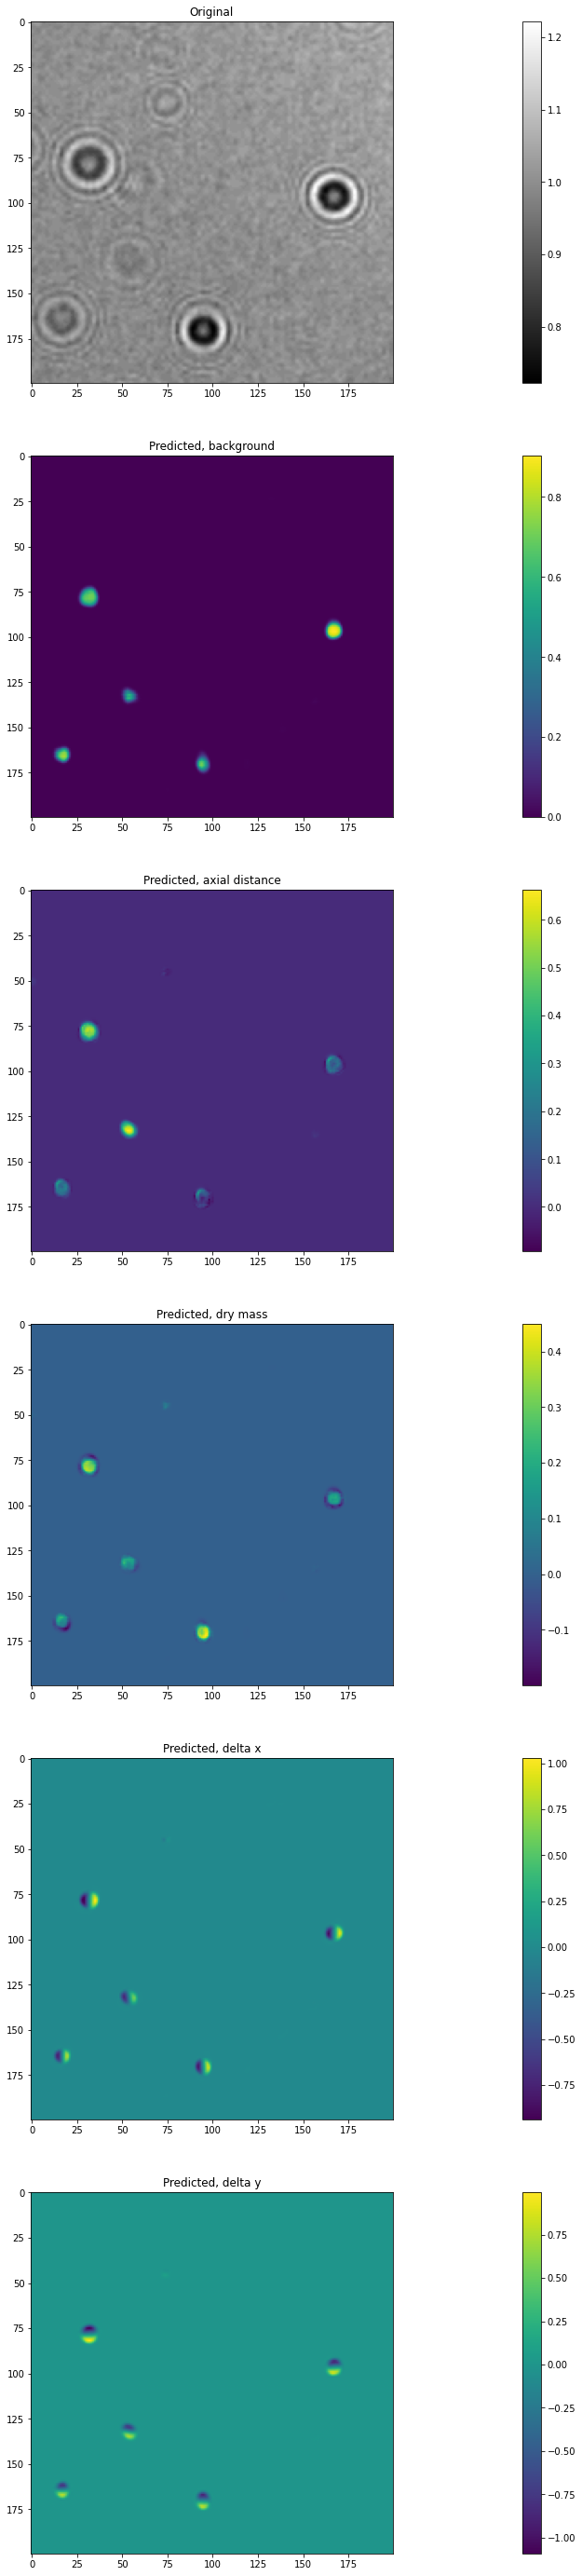

In [27]:
#predictions
fig=plt.figure(figsize=(50,50))

[a,b,c,d]=[680,880,375,575]

plt.subplot(6,1,1)
plt.imshow((experimental_image/np.median(experimental_image))[a:b, c:d] , cmap="gray")
plt.title("Original")
plt.colorbar()

plt.subplot(6,1,2)
plt.imshow(np.squeeze(predicted_image[:, :, :, 0]) [a:b, c:d]) 
plt.title("Predicted, background")
plt.colorbar()

plt.subplot(6,1,3)
plt.imshow(np.squeeze(predicted_image[:, :, :, 1]) [a:b, c:d]) 
plt.title("Predicted, axial distance")
plt.colorbar()

plt.subplot(6,1,4)
plt.imshow(np.squeeze(predicted_image[:, :, :, 2]) [a:b, c:d]) 
plt.title("Predicted, dry mass")
plt.colorbar()

plt.subplot(6,1,5)
plt.imshow(np.squeeze(predicted_image[:, :, :, 3]) [a:b, c:d]) 
plt.title("Predicted, delta x")
plt.colorbar()

plt.subplot(6,1,6)
plt.imshow(np.squeeze(predicted_image[:, :, :, 4]) [a:b, c:d]) 
plt.title("Predicted, delta y")
plt.colorbar()

plt.show()
